# Desafío 2

- Ignacio de Pedro Mermier
- Cohorte 17

## Consigna

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

In [ ]:
%pip install gensim keras tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Obtención de Datos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

/usr/lib/python3/dist-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 45.0.0.
  "class": algorithms.Blowfish,
/usr/lib/python3/dist-packages/paramiko/transport.py:261: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Posibles bandas
os.listdir("./songs_dataset/")

['nursery_rhymes.txt',
 'paul-simon.txt',
 'amy-winehouse.txt',
 'prince.txt',
 'bjork.txt',
 'lady-gaga.txt',
 'adele.txt',
 'drake.txt',
 'janisjoplin.txt',
 'nicki-minaj.txt',
 'dj-khaled.txt',
 'Lil_Wayne.txt',
 'johnny-cash.txt',
 'jimi-hendrix.txt',
 'bob-dylan.txt',
 'nickelback.txt',
 'bruce-springsteen.txt',
 'notorious_big.txt',
 'patti-smith.txt',
 'Kanye_West.txt',
 'lin-manuel-miranda.txt',
 'beatles.txt',
 'r-kelly.txt',
 'bruno-mars.txt',
 'al-green.txt',
 'kanye-west.txt',
 'bieber.txt',
 'lorde.txt',
 'missy-elliott.txt',
 'dolly-parton.txt',
 'dr-seuss.txt',
 'nirvana.txt',
 'ludacris.txt',
 'blink-182.txt',
 'britney-spears.txt',
 'disney.txt',
 'cake.txt',
 'radiohead.txt',
 'rihanna.txt',
 'michael-jackson.txt',
 'leonard-cohen.txt',
 'kanye.txt',
 'notorious-big.txt',
 'eminem.txt',
 'dickinson.txt',
 'joni-mitchell.txt',
 'lil-wayne.txt',
 'alicia-keys.txt',
 'bob-marley.txt']

En el presente desafío vamos a analizar las canciones de bob marley

In [5]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/bob-marley.txt', sep='/n', header=None)
df.head()

/tmp/ipykernel_12037/920653701.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/bob-marley.txt', sep='/n', header=None)


,0
0,"""Don't worry about a thing,"
1,'Cause every little thing gonna be all right.
2,"Singin': ""Don't worry about a thing,"
3,"'Cause every little thing gonna be all right!""..."
4,"Smiled with the risin' sun,"


In [6]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2218


In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

2025-04-02 16:53:18.360781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 16:53:18.365112: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 16:53:18.377958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743623598.400085   12037 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743623598.406643   12037 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743623598.424078   12037 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
# Agregamos el parametro last_loss para utilizarlo como parámetro de comparación entre modelos
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
            self.last_loss = loss- self.loss_previous_step
        self.epoch += 1
        self.loss_previous_step = loss
        
        

In [ ]:
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [11]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [12]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 532


In [72]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback

loss_logger = callback()

w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[loss_logger]
                 )
print('-'*40)
print(f'Final last loss: {loss_logger.last_loss}')

Loss after epoch 0: 103327.0625
Loss after epoch 1: 101728.640625
Loss after epoch 2: 102984.015625
Loss after epoch 3: 99916.03125
Loss after epoch 4: 100519.59375
Loss after epoch 5: 97664.59375
Loss after epoch 6: 98117.875
Loss after epoch 7: 96648.125
Loss after epoch 8: 97633.0625
Loss after epoch 9: 97822.0
Loss after epoch 10: 95979.75
Loss after epoch 11: 95957.375
Loss after epoch 12: 95453.25
Loss after epoch 13: 95185.0
Loss after epoch 14: 93934.375
Loss after epoch 15: 94836.5
Loss after epoch 16: 96038.625
Loss after epoch 17: 93552.625
Loss after epoch 18: 93586.75
Loss after epoch 19: 96823.125
----------------------------------------
Final last loss: 96823.125


## Encontrando los mejores modelos

Para encontrar el mejor modelo que se amolde a las caciones de Bob Marley, vamos a iterar sobre los siguiente hiperparámtros del "Word2Vec":
- Modelo: CBOW o Skipgram
- Min coun: mínima cantidad de apariciones de las palabras para que sea considerada
- Window: ventana para tomar el contexto
- Vector: dimensionalidad de los vectores de las palabras
- Negative: Cantidad de "palabras de ruido" (noise words) para los falsos negativos

In [51]:
# Parametro de smothing de los modelos
model_lst       = [0, 1]

min_count_lst   = [1, 5]
window_lst      = [1, 2, 5]
vector_size_lst = [100, 300, 500]
negative_lst    = [10, 20, 50]


results = []

for min_count in min_count_lst:
    for window in window_lst:
        for vector_size in vector_size_lst:
            for negative in negative_lst:
                for model in model_lst:
                    print('=' * 40)
                    if model == 0:
                        model_name = 'CBOW'
                    if model == 1:
                        model_name = 'Skipgram'
                    print(f'model: {model_name}')
                    print(f'window: {window}')
                    print(f'vector_size: {vector_size}')
                    print(f'negative: {negative}')
                    print(f'min_count: {min_count}')
                    cb = callback()
                    # En este caso utilizaremos la estructura modelo Skipgram
                    w2v_model = Word2Vec(
                                        min_count   = min_count,    # frecuencia mínima de palabra para incluirla en el vocabulario
                                        window      = window,       # cant de palabras antes y desp de la predicha
                                        vector_size = vector_size,       # dimensionalidad de los vectores 
                                        negative    = negative,    # cantidad de negative samples... 0 es no se usa
                                        workers     = 1,      # si tienen más cores pueden cambiar este valor
                                        sg          = model)           # modelo 0:CBOW  1:skipgram
                    
                    # Obtener el vocabulario con los tokens
                    w2v_model.build_vocab(sentence_tokens)

                    # Entrenamos el modelo generador de vectores
                    # Utilizamos nuestro callback
                    loss_data = []
                    w2v_model.train(sentence_tokens,
                                    total_examples=w2v_model.corpus_count,
                                    epochs=20,
                                    compute_loss = True,
                                    callbacks=[cb]
                                    )
                    print('-' * 40)
                    print(f'loss: {cb.last_loss}')
                    result = {
                        'model':        model_name,
                        'min_count':    min_count,
                        'window':       window,
                        'vector_size':  vector_size,
                        'negative':     negative,
                        'loss':         cb.last_loss,
                    
                    }
                    results.append(result)


model: CBOW
window: 1
vector_size: 100
negative: 10
min_count: 1
Loss after epoch 0: 99707.7421875
Loss after epoch 1: 70867.4140625
Loss after epoch 2: 56008.421875
Loss after epoch 3: 50964.796875
Loss after epoch 4: 48950.25
Loss after epoch 5: 47535.3125
Loss after epoch 6: 46453.0
Loss after epoch 7: 45432.09375
Loss after epoch 8: 43904.5
Loss after epoch 9: 42173.21875
Loss after epoch 10: 40906.0
Loss after epoch 11: 39599.5
Loss after epoch 12: 38366.3125
Loss after epoch 13: 37598.75
Loss after epoch 14: 36762.5
Loss after epoch 15: 36333.0
Loss after epoch 16: 35559.5625
Loss after epoch 17: 35061.5
Loss after epoch 18: 34999.1875
Loss after epoch 19: 34503.3125
----------------------------------------
loss: 34503.3125
model: Skipgram
window: 1
vector_size: 100
negative: 10
min_count: 1
Loss after epoch 0: 155475.3125
Loss after epoch 1: 103308.359375
Loss after epoch 2: 85949.578125
Loss after epoch 3: 79496.375
Loss after epoch 4: 76484.84375
Loss after epoch 5: 73652.9062

Obtenemos los 3 mejores modelos con la función de costo de la última época menor

In [76]:
# Ordenar los resultados segun el f1-score
sorted_results = sorted(results, key=lambda x: x['loss'], reverse=False)
for i, result in enumerate(sorted_results[:3], start=1):
    print(f"Result {i}:")
    print(f"  Model: {result['model']}")
    print(f"  Min Count: {result['min_count']}")
    print(f"  Window: {result['window']}")
    print(f"  Vector Size: {result['vector_size']}")
    print(f"  Negative: {result['negative']}")
    print(f"  Loss {result['loss']:.4f}")
    
    
    
    if result['model'] == 'CBOW':
        model = 0
    elif result['model'] == 'Skipgram':
        model = 1
    if i == 1:
        w2v_model_1 = Word2Vec(
                    min_count   = result['min_count'],      # frecuencia mínima de palabra para incluirla en el vocabulario
                    window      = result['window'],         # cant de palabras antes y desp de la predicha
                    vector_size = result['vector_size'],    # dimensionalidad de los vectores 
                    negative    = result['negative'],       # cantidad de negative samples... 0 es no se usa
                    workers     = 1,                        # si tienen más cores pueden cambiar este valor
                    sg          = model,)         # modelo 0:CBOW  1:skipgram

        # Obtener el vocabulario con los tokens
        w2v_model_1.build_vocab(sentence_tokens)
        cb = callback()
        loss_data = []
        w2v_model_1.train(sentence_tokens,
                        total_examples=w2v_model.corpus_count,
                        epochs=20,
                        compute_loss = True,
                        #callbacks=[cb]
                        )
        V = len(w2v_model_1.wv)  # Tamaño del vocabulario
        N = w2v_model_1.vector_size  # Dimensión de los embeddings

        total_params = V * N * 2
        print(f"  Total de parámetros: {total_params:,}")
        
    elif i == 2:
          
        w2v_model_2 = Word2Vec(
                    min_count   = result['min_count'],      # frecuencia mínima de palabra para incluirla en el vocabulario
                    window      = result['window'],         # cant de palabras antes y desp de la predicha
                    vector_size = result['vector_size'],    # dimensionalidad de los vectores 
                    negative    = result['negative'],       # cantidad de negative samples... 0 es no se usa
                    workers     = 1,                        # si tienen más cores pueden cambiar este valor
                    sg          = model,)         # modelo 0:CBOW  1:skipgram

        # Obtener el vocabulario con los tokens
        w2v_model_2.build_vocab(sentence_tokens)
        cb = callback()
        w2v_model_2.train(sentence_tokens,
                        total_examples=w2v_model.corpus_count,
                        epochs=20,
                        compute_loss = True,
                        #callbacks=[cb]
                        )
        V = len(w2v_model_2.wv)  # Tamaño del vocabulario
        N = w2v_model_2.vector_size  # Dimensión de los embeddings

        total_params = V * N * 2
        print(f"  Total de parámetros: {total_params:,}")
        
    elif i == 3:
        w2v_model_3 = Word2Vec(
                    min_count   = result['min_count'],      # frecuencia mínima de palabra para incluirla en el vocabulario
                    window      = result['window'],         # cant de palabras antes y desp de la predicha
                    vector_size = result['vector_size'],    # dimensionalidad de los vectores 
                    negative    = result['negative'],       # cantidad de negative samples... 0 es no se usa
                    workers     = 1,                        # si tienen más cores pueden cambiar este valor
                    sg          = model,)         # modelo 0:CBOW  1:skipgram

        # Obtener el vocabulario con los tokens
        w2v_model_3.build_vocab(sentence_tokens)
        cb = callback()
        w2v_model_3.train(sentence_tokens,
                        total_examples=w2v_model.corpus_count,
                        epochs=20,
                        compute_loss = True,
                        #callbacks=[cb]
                        )
        V = len(w2v_model_3.wv)  # Tamaño del vocabulario
        N = w2v_model_3.vector_size  # Dimensión de los embeddings

        total_params = V * N * 2
        print(f"  Total de parámetros: {total_params:,}")
            
    print('-' * 40)
                    
                    
    

Result 1:
  Model: CBOW
  Min Count: 5
  Window: 5
  Vector Size: 100
  Negative: 10
  Loss 26544.8125
  Total de parámetros: 106,400
----------------------------------------
Result 2:
  Model: CBOW
  Min Count: 5
  Window: 2
  Vector Size: 100
  Negative: 10
  Loss 27475.5000
  Total de parámetros: 106,400
----------------------------------------
Result 3:
  Model: CBOW
  Min Count: 5
  Window: 5
  Vector Size: 300
  Negative: 10
  Loss 27561.1875
  Total de parámetros: 319,200
----------------------------------------


Se observan que en los 3 casos, se utiliza el modelo "CBOW" por sobre el modelo "Skipgram", se utiliza un "min_count de 5 (por sobre el "min_count" de 1) y un "negative" de 10. Las diferencias radican entre el tamaño de la ventana a utilizar, 5 para el primer y tercer modelo, y 2 para el segundo modelo; y el tamaño del vector a utilizar, siendo 100 para los primeros modelos y 300 para el tercer modelo, multiplicando por 3 la cantidad de parámetros que utiliza este último.

In [57]:
# Palabras que MÁS se relacionan con...:
w2v_model_1.wv.most_similar(positive=["dreadlock"], topn=10)

[('rasta', 0.9921627044677734),
 ('yea', 0.9723864793777466),
 ('buffalo', 0.9581881165504456),
 ('soldier', 0.95614093542099),
 ('blowing', 0.9388744831085205),
 ('ho', 0.9301965832710266),
 ('mystic', 0.9298956394195557),
 ('america', 0.9288665056228638),
 ('air', 0.9276933670043945),
 ('as', 0.9273395538330078)]

In [58]:
# Palabras que MÁS se relacionan con...:
w2v_model_2.wv.most_similar(positive=["dreadlock"], topn=10)

[('rasta', 0.9926614165306091),
 ('blowing', 0.9889602065086365),
 ('pale', 0.9876474738121033),
 ('mystic', 0.9871924519538879),
 ('natural', 0.9859579801559448),
 ('fit', 0.9858707189559937),
 ('corner', 0.985675036907196),
 ('cap', 0.9848899841308594),
 ('scaba', 0.984283983707428),
 ('air', 0.9839828014373779)]

In [59]:
# Palabras que MÁS se relacionan con...:
w2v_model_3.wv.most_similar(positive=["dreadlock"], topn=10)

[('rasta', 0.9945492744445801),
 ('yea', 0.9812427759170532),
 ('soldier', 0.9650501608848572),
 ('buffalo', 0.9637197852134705),
 ('ho', 0.9562996625900269),
 ('twelve', 0.9560397863388062),
 ('america', 0.9548574090003967),
 ('blowing', 0.9547551274299622),
 ("groovin'", 0.9545043110847473),
 ('natural', 0.9485208988189697)]

Al analizar las 10 palabras más similiares a la palabra "dreadlock" en ambos modelos, las 3 coinciden con la palabra "rasta", la cual hace referencia en ingles a un "Rastafaria", el cual se caracteriza por tener "rastas" en el pelo. A su vez, los 3 modelos comparten algunas palabras en sus listas, como: "yea", "blowng", "buffalo", "soldier", sobre todo entre el primer y el tercer modelo. Sin embargo, se puede apreciar que en los 3 casos, hay palabras con un alto grado de similitud, que no aparecen en ninguno de los otros dos modelos, como: "cap", "groovin" y "corner".

## Visualización de los Datos

__Nota:__ Al correrlo dentro de un notebook de VSCode, la función _"fig.show(renderer="colab")"_ fallaba, por lo que se uso al función _"fig.show(renderer="browser")_ en su lugar, por lo que el análisis presente se realizó utilizando el navegador del cual se extrajeron las imágenes presentes en este documento. 

In [ ]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np 

# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px                                

def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [66]:
vecs, labels = reduce_dimensions(w2v_model_1)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="browser") # esto para plotly en colab

In [67]:
vecs, labels = reduce_dimensions(w2v_model_2)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="browser") # esto para plotly en colab

In [68]:
vecs, labels = reduce_dimensions(w2v_model_3)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="browser") # esto para plotly en colab

Al analizar de manera global los 3 modelos no se observan diferencias claras entre los distintos "clusters"

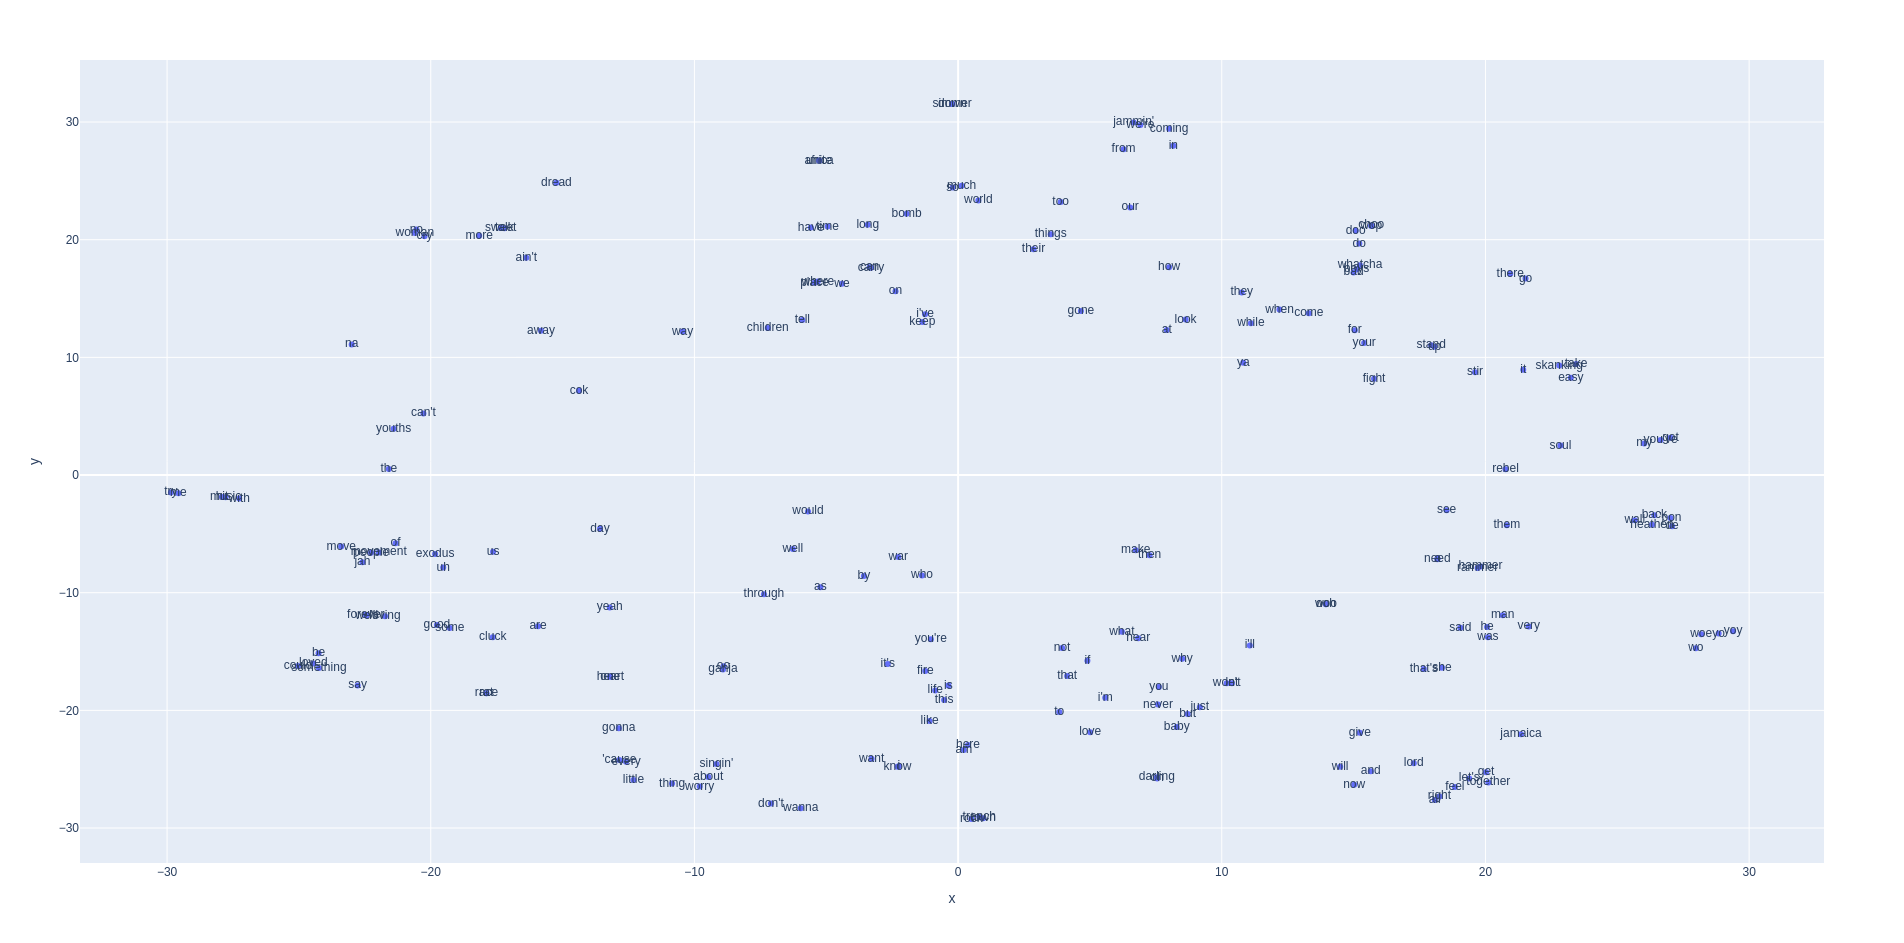

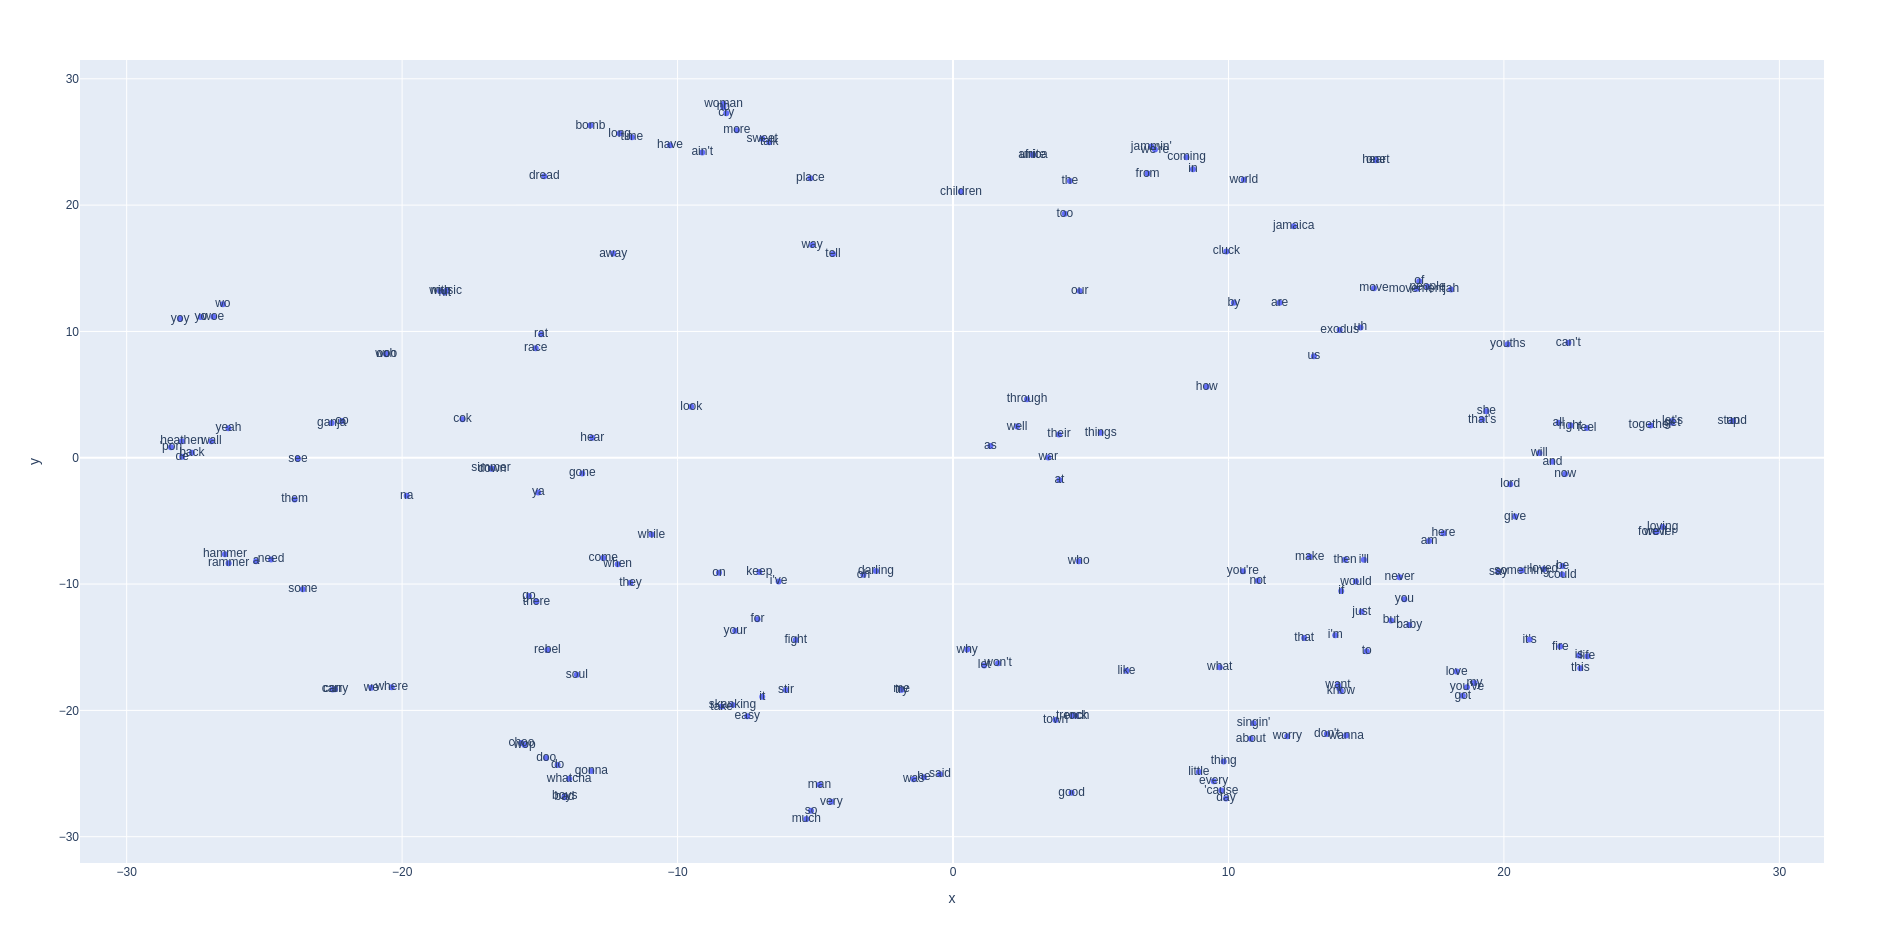

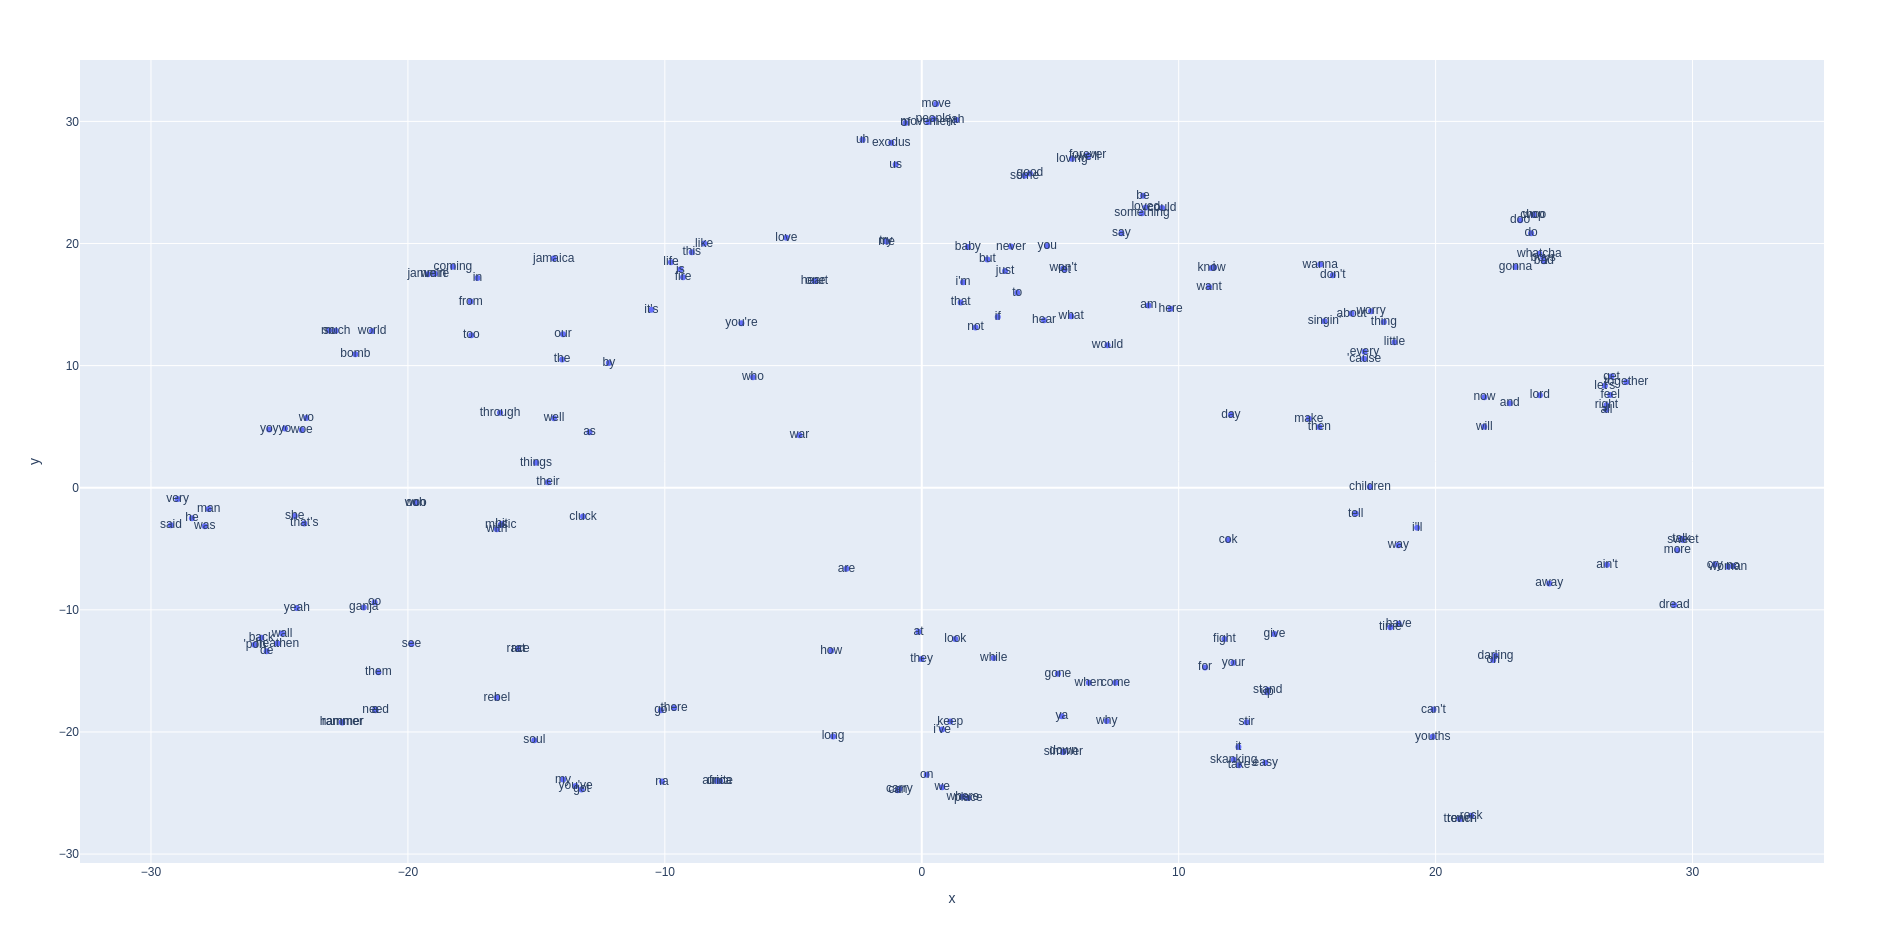

Al analizar algunos clusters en particular, por ejemplo, el cluster cercano a la palabra "People", podemos observar que en los 3 modelos posee las mismas palabras cercanas: "Move", "Movement", "of" y "Jah".


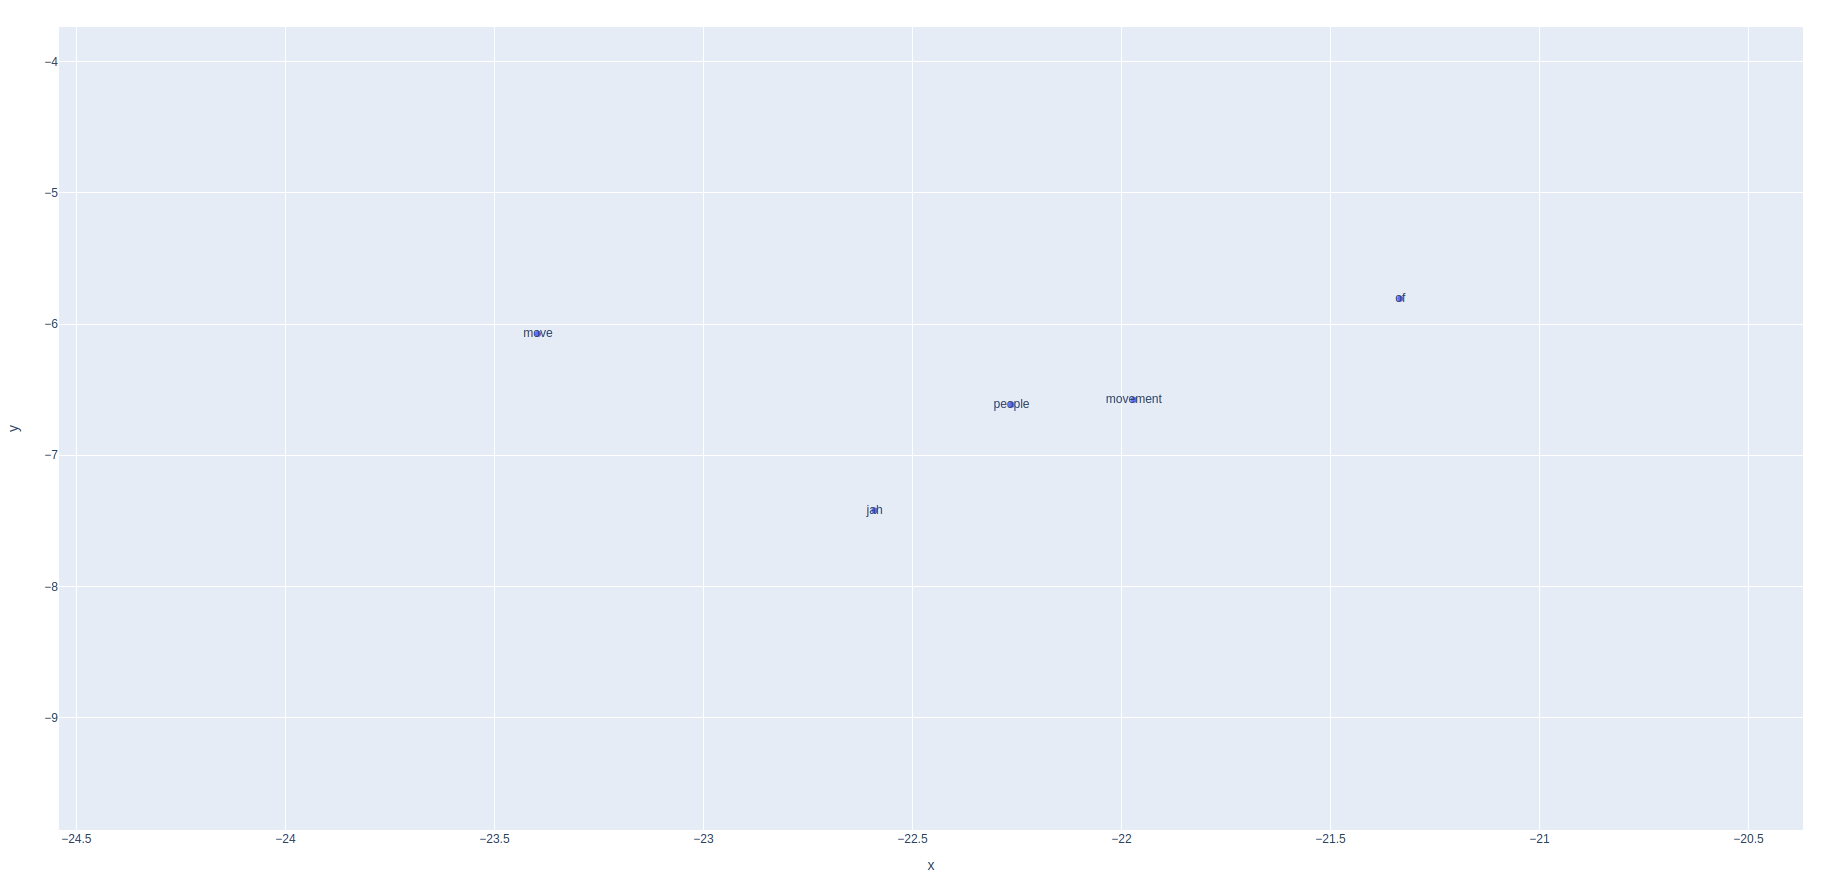

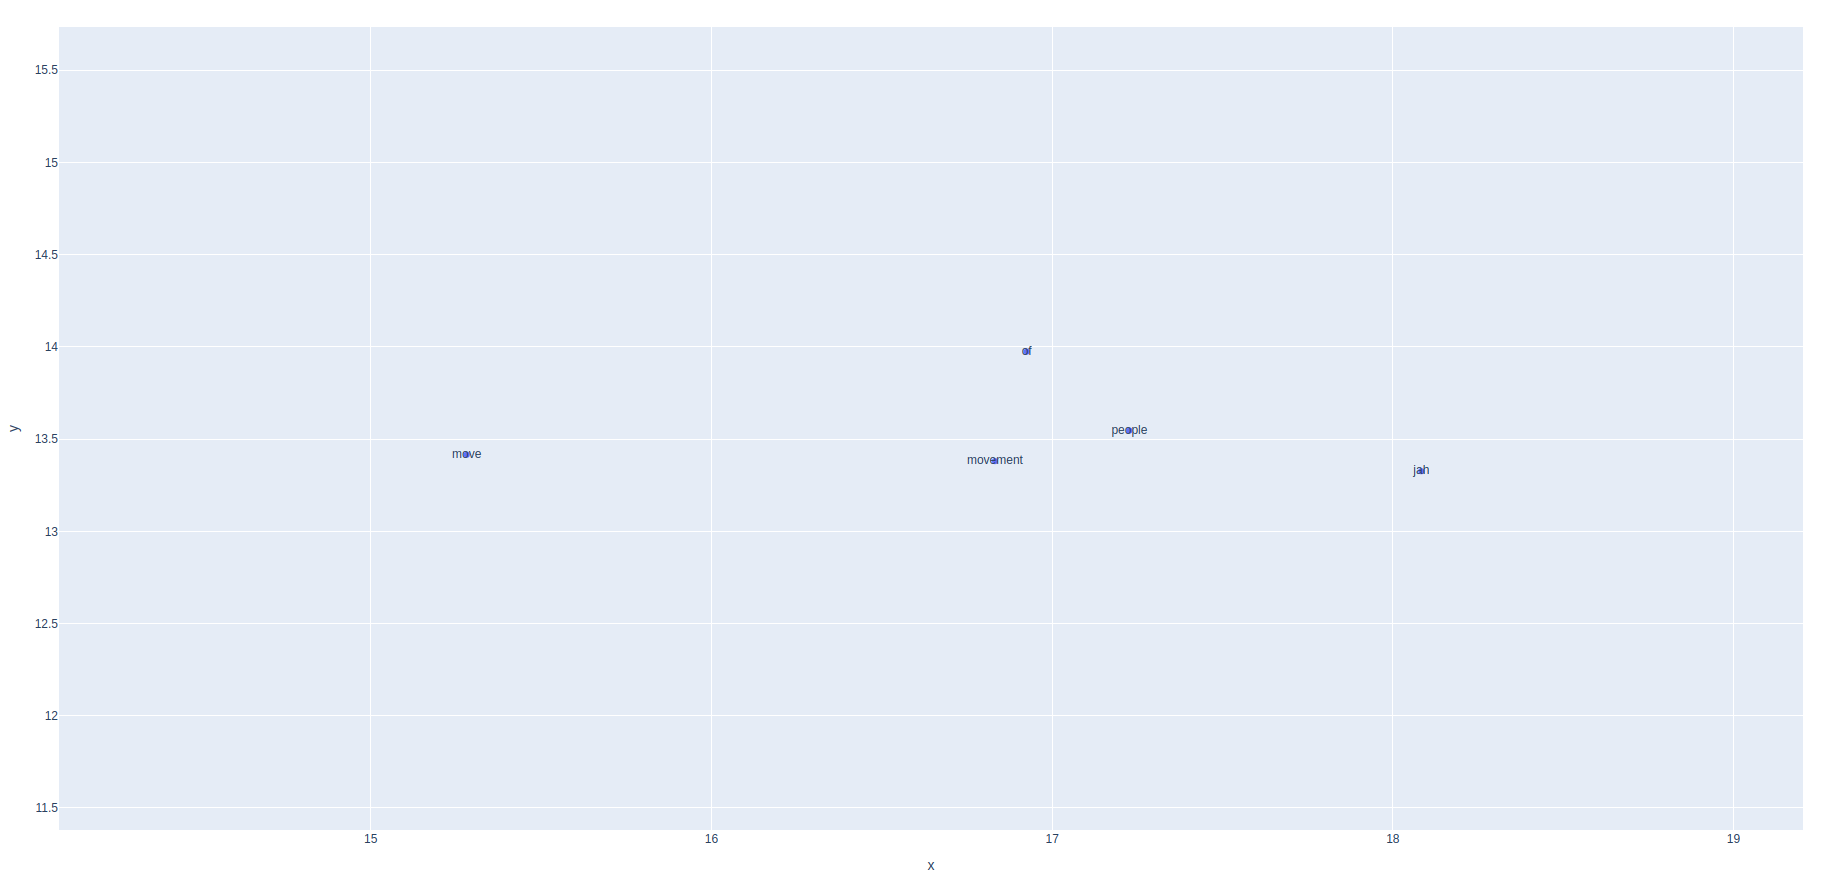

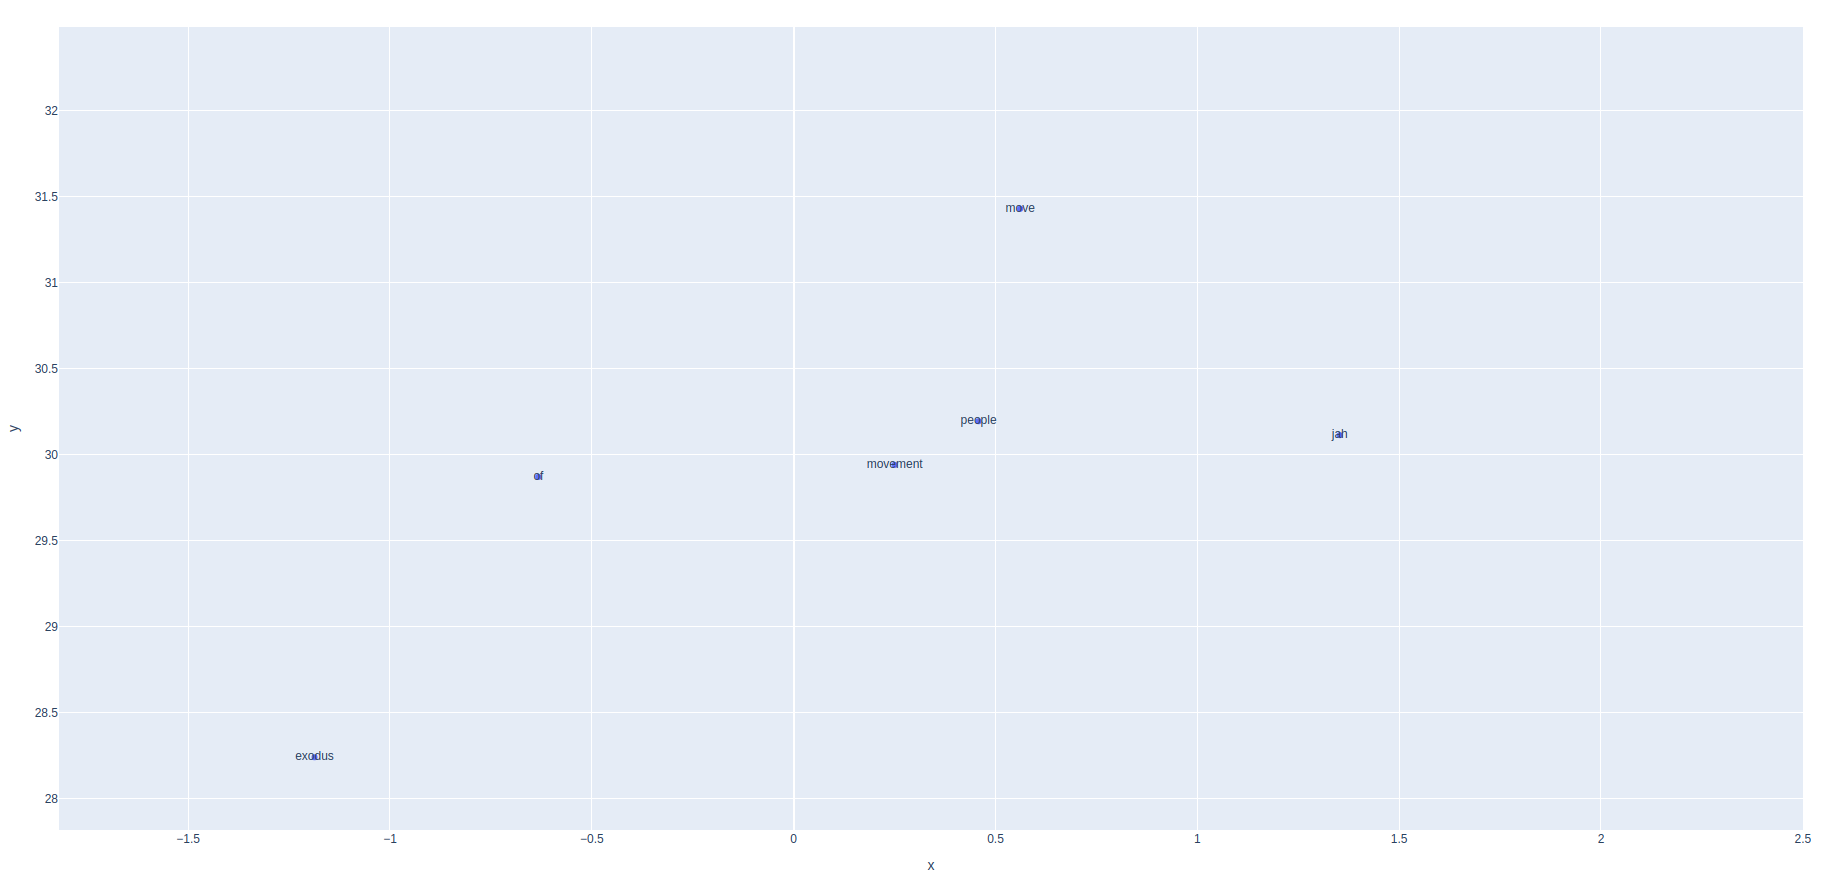

Sin embargo, al realizar el mismo análisis sobre la palabra "man", se observa un comportamiento similar entre los modelos 1 y 3, ya que estos agrupan en su cercanía a las palabras: "Said", "he", "was" y "very"; mientras que el modelo 2 posee en su ceranía a las palabras: "very", "so" y "much".

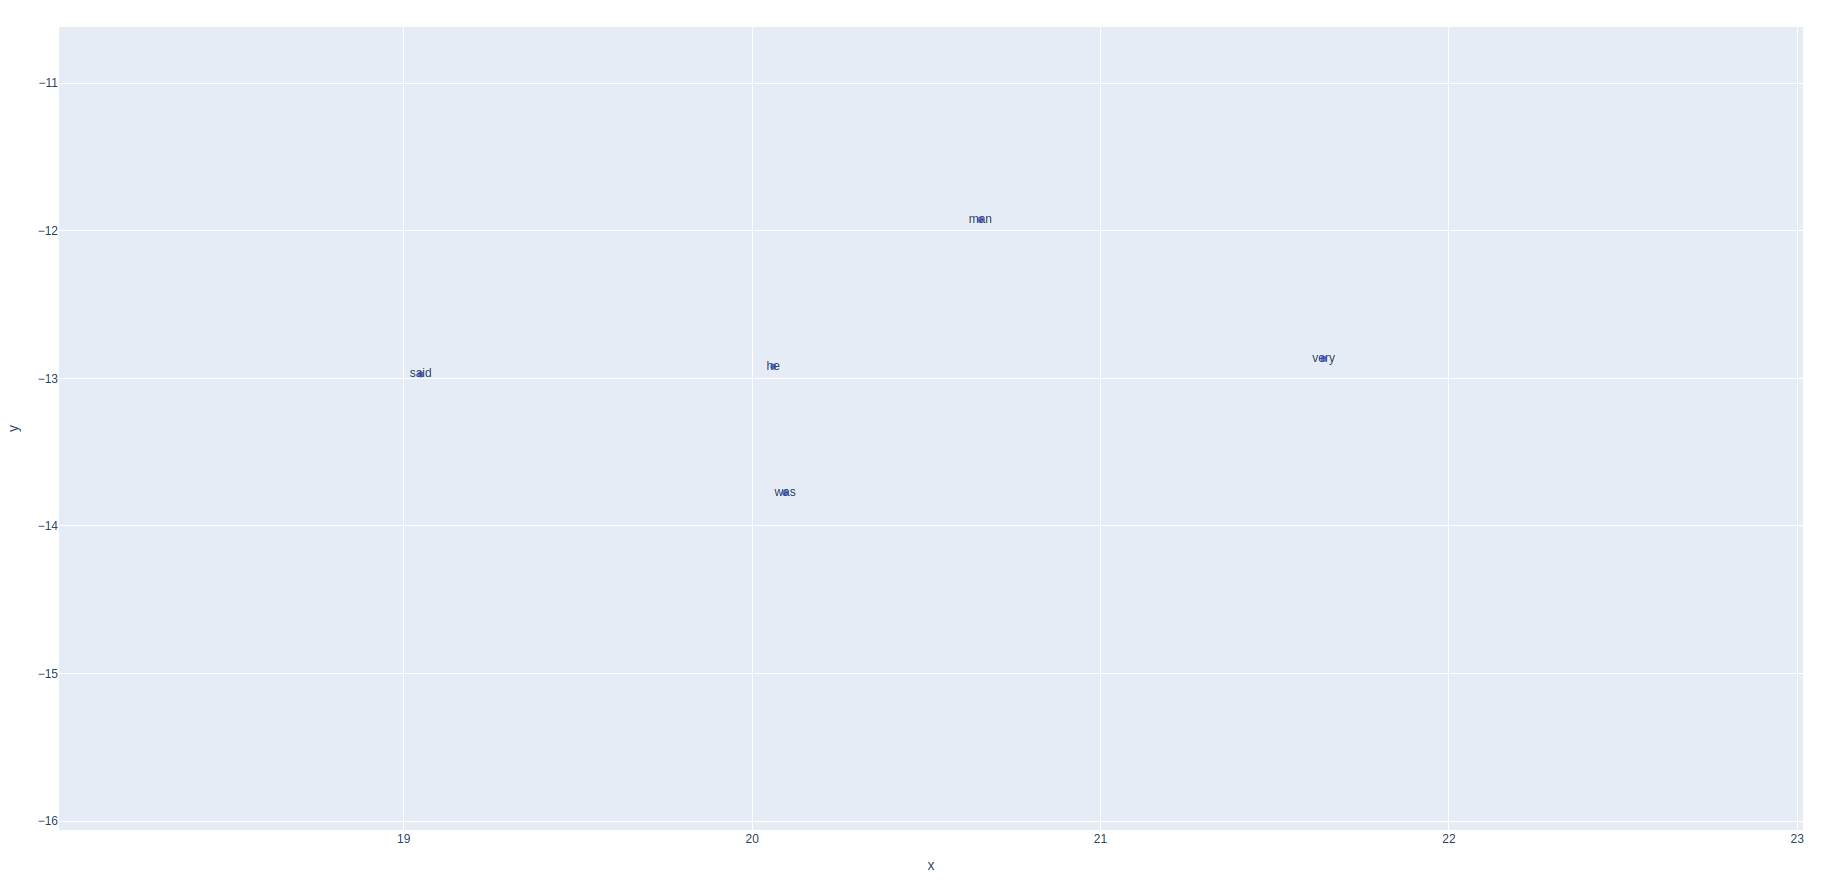

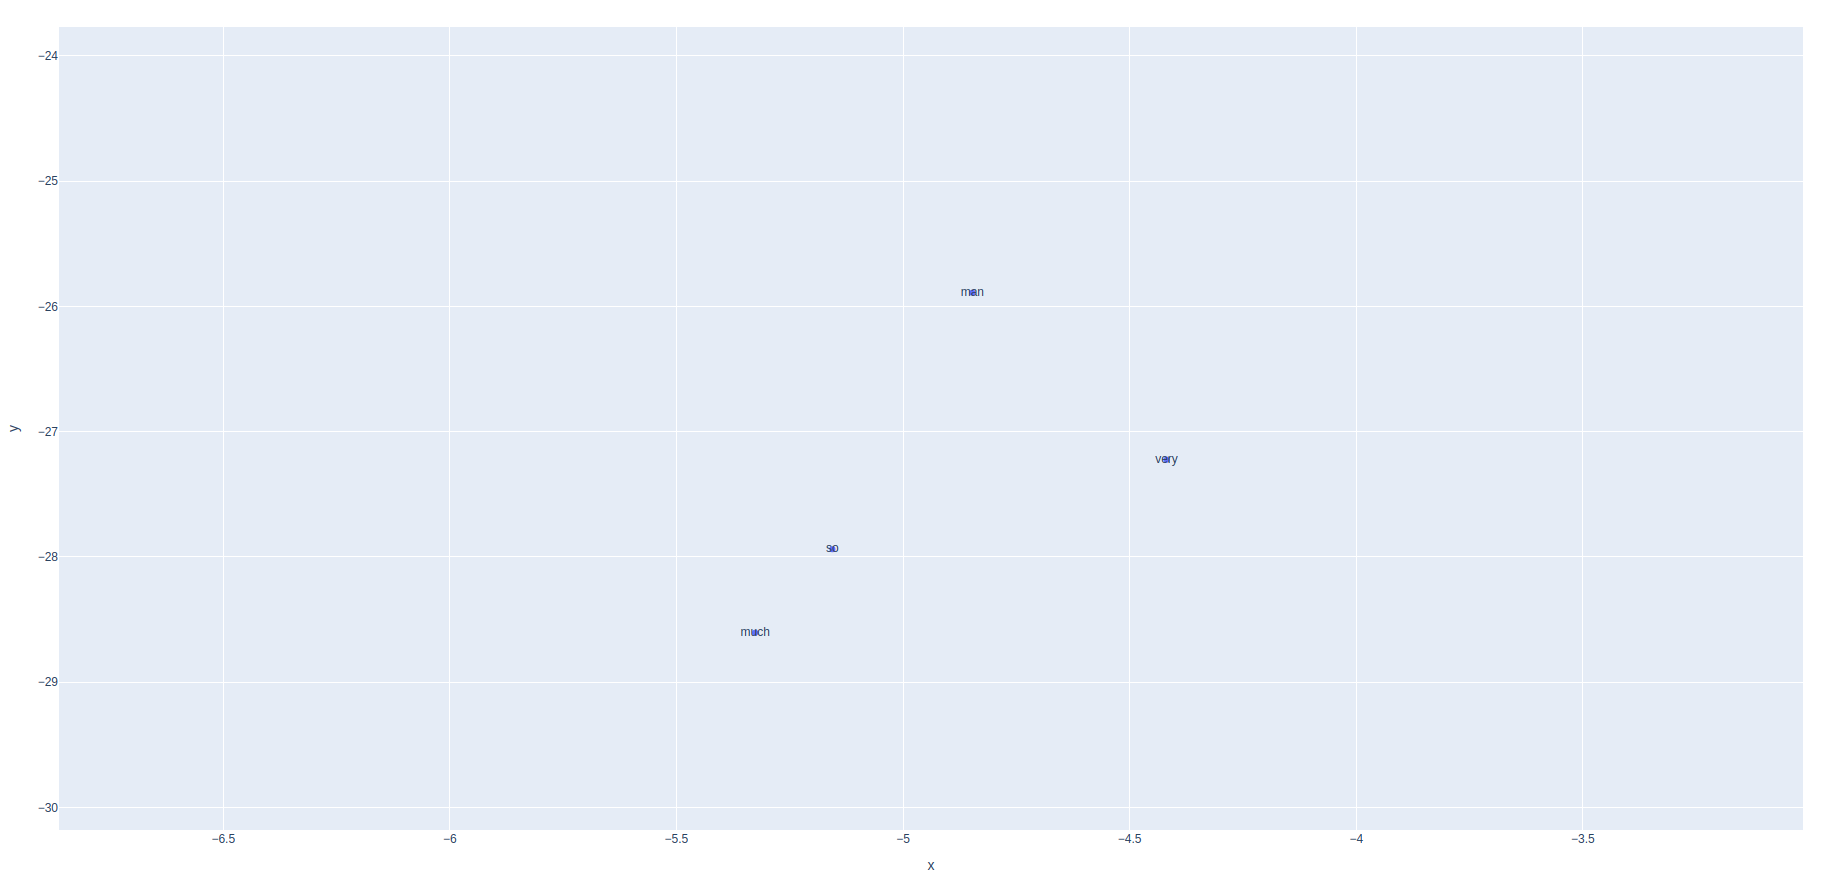

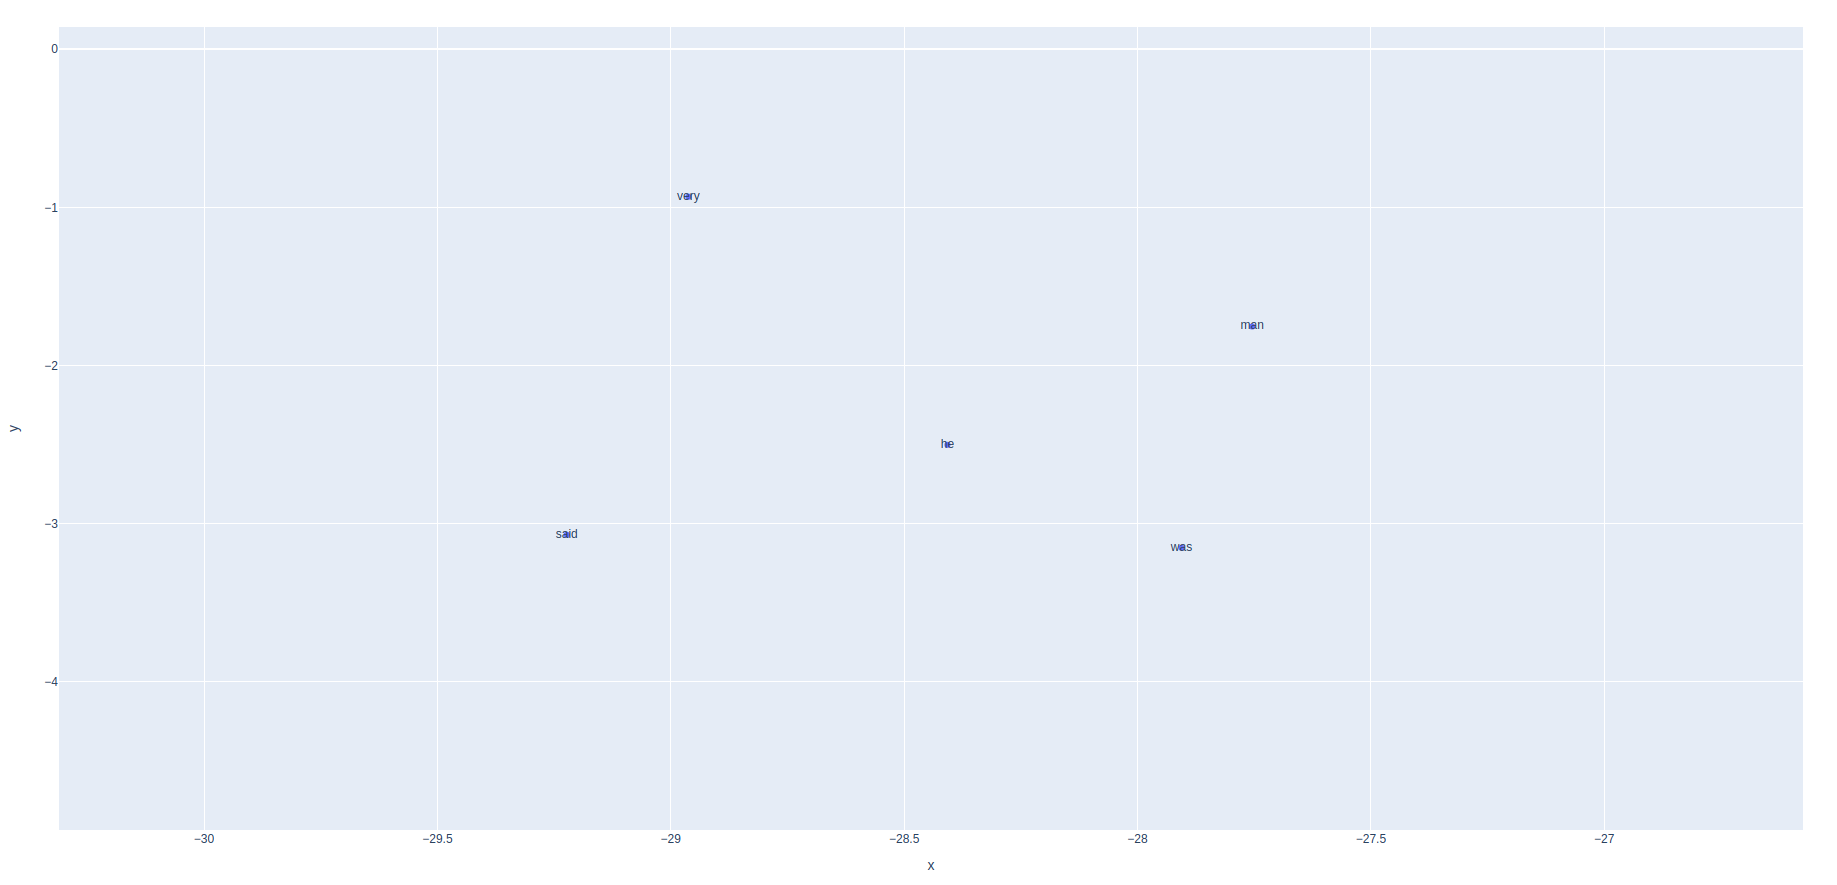

Generamos los documentos _.tsv_ de vectores y labels para cada modelo con el fin de poder observar su coportamiento en la herramienta _http://projector.tensorflow.org/_ 

In [69]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model_1.wv.vectors)
labels = list(w2v_model_1.wv.index_to_key)

np.savetxt("vectors_model_1.tsv", vectors, delimiter="\t")

with open("labels_model_1.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)
        
vectors = np.asarray(w2v_model_2.wv.vectors)
labels = list(w2v_model_2.wv.index_to_key)

np.savetxt("vectors_model_2.tsv", vectors, delimiter="\t")

with open("labels_model_2.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)
        
vectors = np.asarray(w2v_model_3.wv.vectors)
labels = list(w2v_model_3.wv.index_to_key)

np.savetxt("vectors_model_3.tsv", vectors, delimiter="\t")

with open("labels_model_3.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)